In [2]:
import numpy as np, tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import json

import os, numpy as np, tensorflow as tf, pathlib
from sklearn.model_selection import train_test_split
import pathlib
import matplotlib.pyplot as plt

In [14]:
SEED = 42
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

# UPDATE THIS PATH:
DATA_ROOT = "Project"

# Set seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("=" * 80)
print("HURRICANE HARVEY BUILDING DAMAGE CLASSIFICATION PROJECT")
print("=" * 80)

HURRICANE HARVEY BUILDING DAMAGE CLASSIFICATION PROJECT


In [15]:
print("\n" + "=" * 80)
print("PART 1: DATA PREPROCESSING AND VISUALIZATION")
print("=" * 80)


PART 1: DATA PREPROCESSING AND VISUALIZATION


In [16]:
print("\n[Step 1.1] Loading Data...")

def list_images(folder):
    p = pathlib.Path(folder)
    if not p.exists():
        return []
    return sorted([str(f) for f in p.iterdir()
                   if f.is_file() and f.suffix.lower() in ('.jpg', '.jpeg', '.png')])

damage_dir = os.path.join(DATA_ROOT, "damage")
no_damage_dir = os.path.join(DATA_ROOT, "no_damage")

if not os.path.exists(damage_dir):
    raise FileNotFoundError(f"Missing folder: {damage_dir}")
if not os.path.exists(no_damage_dir):
    raise FileNotFoundError(f"Missing folder: {no_damage_dir}")

damage_paths = list_images(damage_dir)
no_damage_paths = list_images(no_damage_dir)

X_paths = np.array(damage_paths + no_damage_paths, dtype=object)
y_labels = np.array([1]*len(damage_paths) + [0]*len(no_damage_paths), dtype=np.int32)

print(f"Total images: {len(X_paths)}")
print(f"  Damaged: {len(damage_paths)}")
print(f"  No Damage: {len(no_damage_paths)}")


[Step 1.1] Loading Data...
Total images: 5503
  Damaged: 3218
  No Damage: 2285


In [19]:
print("\n[Step 1.2] Investigating Image Attributes...")

def analyze_image(img_path):
    try:
        img = Image.open(img_path)
        return {
            'width': img.width,
            'height': img.height,
            'mode': img.mode,
            'size_kb': os.path.getsize(img_path) / 1024
        }
    except:
        return None

n_samples = min(200, len(X_paths))
sample_indices = np.random.choice(len(X_paths), n_samples, replace=False)

widths, heights, sizes, modes = [], [], [], []
for idx in sample_indices:
    info = analyze_image(X_paths[idx])
    if info:
        widths.append(info['width'])
        heights.append(info['height'])
        sizes.append(info['size_kb'])
        modes.append(info['mode'])

widths = np.array(widths)
heights = np.array(heights)
sizes = np.array(sizes)

print(f"\nImage Statistics:")
print(f"  Width:  min={widths.min()}, max={widths.max()}, mean={widths.mean():.1f}")
print(f"  Height: min={heights.min()}, max={heights.max()}, mean={heights.mean():.1f}")
print(f"  Size:   min={sizes.min():.1f}KB, max={sizes.max():.1f}KB, mean={sizes.mean():.1f}KB")
print(f"  Modes:  {set(modes)}")

unique, counts = np.unique(y_labels, return_counts=True)
imbalance_ratio = max(counts) / min(counts)
print(f"\nClass Distribution:")
print(f"  No Damage (0): {counts[0]} ({counts[0]/len(y_labels)*100:.1f}%)")
print(f"  Damage (1):    {counts[1]} ({counts[1]/len(y_labels)*100:.1f}%)")
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}")


[Step 1.2] Investigating Image Attributes...

Image Statistics:
  Width:  min=128, max=128, mean=128.0
  Height: min=128, max=128, mean=128.0
  Size:   min=1.5KB, max=4.7KB, mean=2.7KB
  Modes:  {'RGB'}

Class Distribution:
  No Damage (0): 2285 (41.5%)
  Damage (1):    3218 (58.5%)
  Imbalance Ratio: 1.41



[Step 1.3] Visualizing Samples...


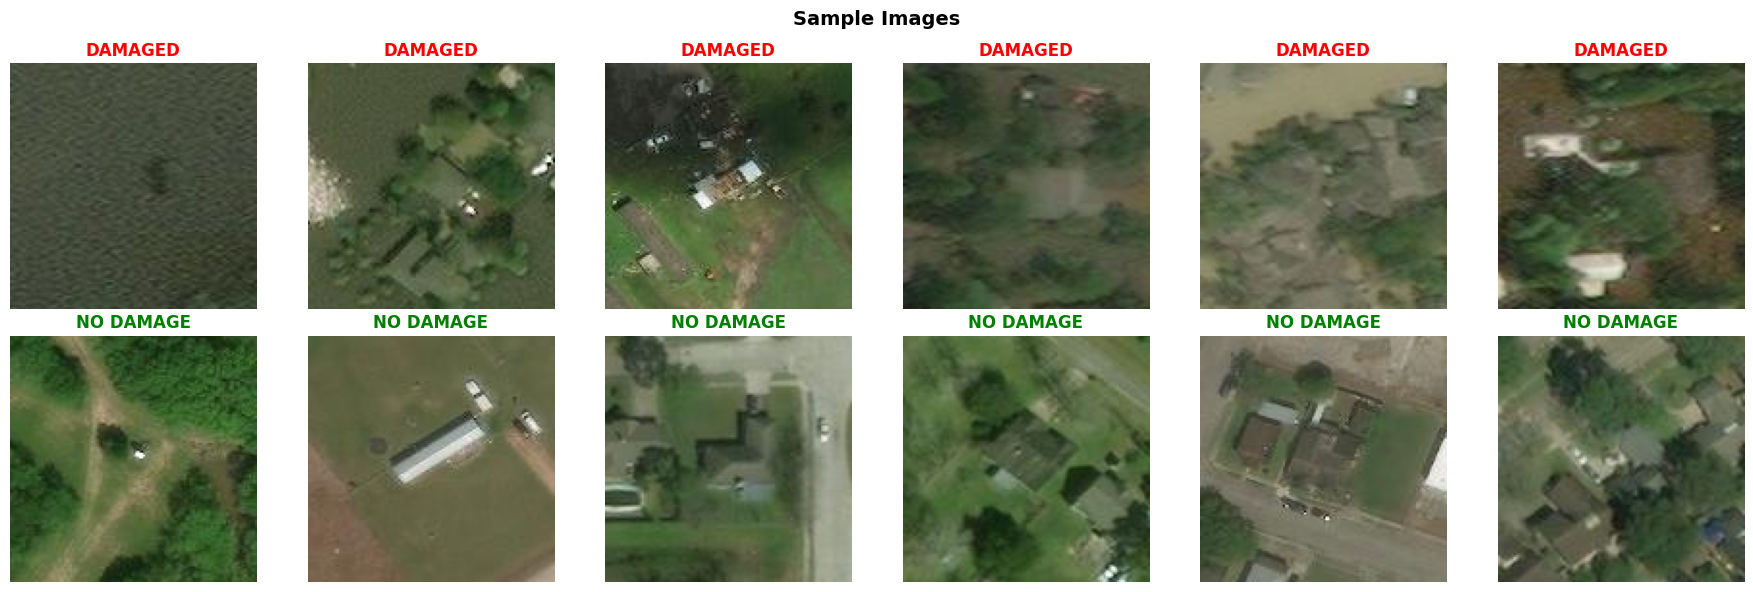

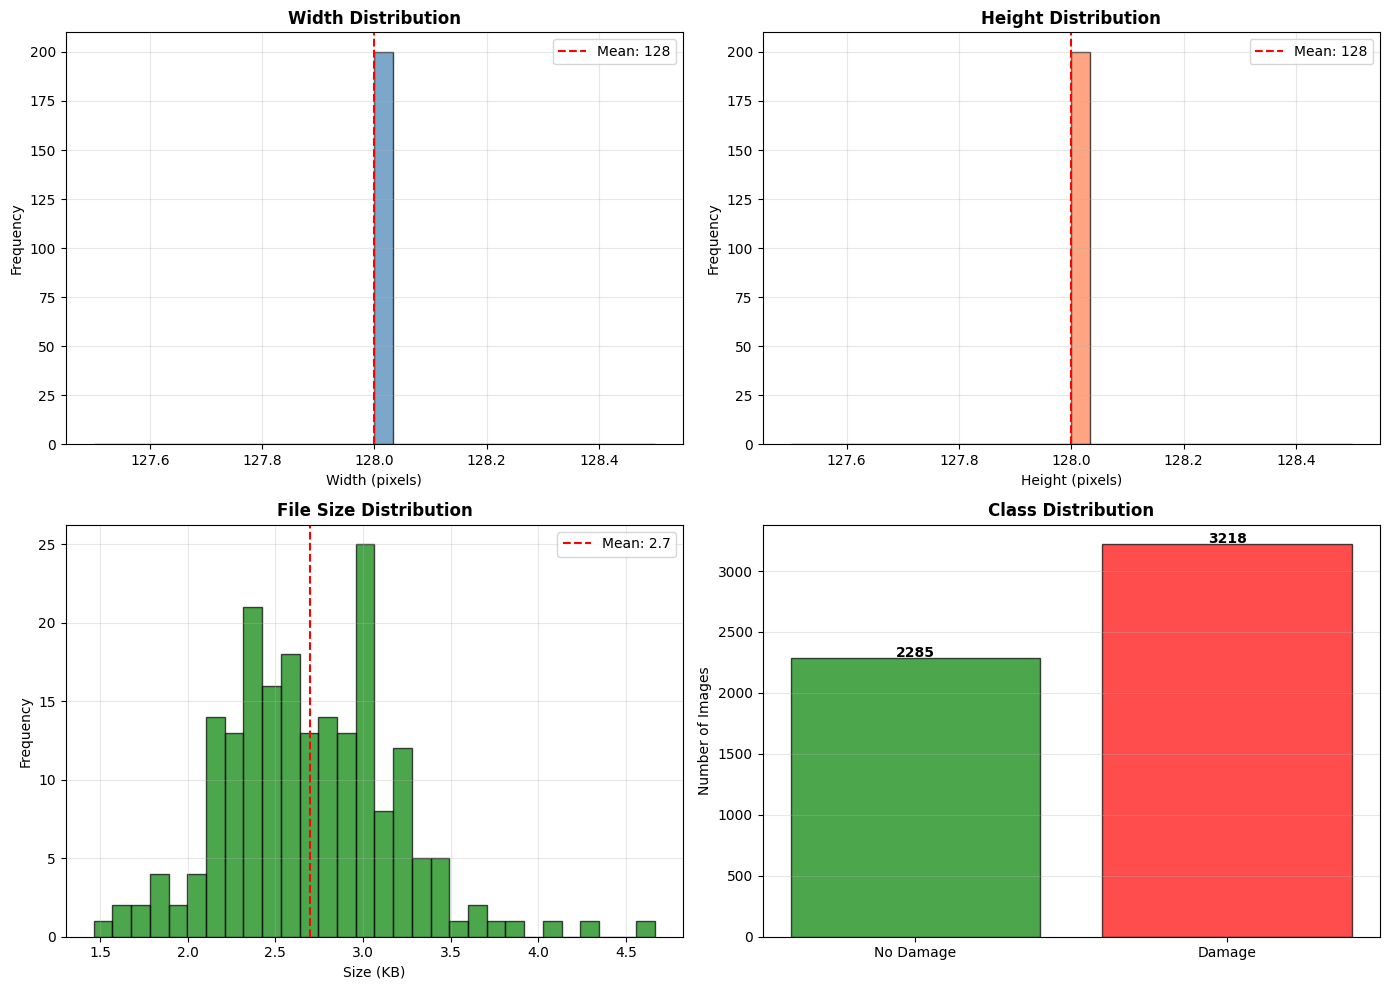

In [25]:
print("\n[Step 1.3] Visualizing Samples...")

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

damage_indices = np.where(y_labels == 1)[0]
damage_samples = np.random.choice(damage_indices, min(6, len(damage_indices)), replace=False)

for i, idx in enumerate(damage_samples):
    img = Image.open(X_paths[idx])
    axes[0, i].imshow(img)
    axes[0, i].set_title('DAMAGED', color='red', fontweight='bold')
    axes[0, i].axis('off')

no_damage_indices = np.where(y_labels == 0)[0]
no_damage_samples = np.random.choice(no_damage_indices, min(6, len(no_damage_indices)), replace=False)

for i, idx in enumerate(no_damage_samples):
    img = Image.open(X_paths[idx])
    axes[1, i].imshow(img)
    axes[1, i].set_title('NO DAMAGE', color='green', fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('Sample Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('part1_samples.png', dpi=150)
plt.show()

# Visualize properties
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(widths, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Width Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(widths.mean(), color='red', linestyle='--', label=f'Mean: {widths.mean():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(heights, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Height Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(heights.mean(), color='red', linestyle='--', label=f'Mean: {heights.mean():.0f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(sizes, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('File Size Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Size (KB)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(sizes.mean(), color='red', linestyle='--', label=f'Mean: {sizes.mean():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].bar(['No Damage', 'Damage'], counts, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Class Distribution', fontweight='bold')
axes[1, 1].set_ylabel('Number of Images')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts):
    axes[1, 1].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('part1_analysis.png', dpi=150)
plt.show()

In [28]:
print("\n[Step 1.4] Splitting Data...")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_paths, y_labels, test_size=0.15, stratify=y_labels, random_state=SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, stratify=y_train_val, random_state=SEED
)

print(f"\nData Split:")
print(f"  Train: {len(X_train)} ({len(X_train)/len(X_paths)*100:.1f}%) - D:{np.sum(y_train==1)}, ND:{np.sum(y_train==0)}")
print(f"  Val:   {len(X_val)} ({len(X_val)/len(X_paths)*100:.1f}%) - D:{np.sum(y_val==1)}, ND:{np.sum(y_val==0)}")
print(f"  Test:  {len(X_test)} ({len(X_test)/len(X_paths)*100:.1f}%) - D:{np.sum(y_test==1)}, ND:{np.sum(y_test==0)}")


[Step 1.4] Splitting Data...

Data Split:
  Train: 3853 (70.0%) - D:2253, ND:1600
  Val:   824 (15.0%) - D:482, ND:342
  Test:  826 (15.0%) - D:483, ND:343


In [30]:
print("\n[Step 1.5] Setting up Preprocessing...")

def load_and_preprocess_image(img_path, target_size=IMG_SIZE):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32)
    
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array] * 3, axis=-1)
    elif img_array.shape[-1] == 4:
        img_array = img_array[:, :, :3]
    
    img_array = img_array / 255.0
    return img_array

def data_generator(X_paths, y_labels, batch_size, augment=False, shuffle=True):
    n_samples = len(X_paths)
    indices = np.arange(n_samples)
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                img = load_and_preprocess_image(X_paths[idx])
                
                if augment:
                    if np.random.rand() > 0.5:
                        img = np.fliplr(img)
                    if np.random.rand() > 0.7:
                        img = np.flipud(img)
                    if np.random.rand() > 0.7:
                        k = np.random.randint(1, 4)
                        img = np.rot90(img, k)
                
                batch_images.append(img)
                batch_labels.append(y_labels[idx])
            
            yield np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.float32)

train_steps = int(np.ceil(len(X_train) / BATCH_SIZE))
val_steps = int(np.ceil(len(X_val) / BATCH_SIZE))
test_steps = int(np.ceil(len(X_test) / BATCH_SIZE))

print(f"Image size: {IMG_SIZE}, Batch size: {BATCH_SIZE}")
print(f"Steps - Train: {train_steps}, Val: {val_steps}, Test: {test_steps}")

# Class weights
class_weights = None
if imbalance_ratio > 1.5:
    total = len(y_train)
    weight_0 = total / (2 * np.sum(y_train == 0))
    weight_1 = total / (2 * np.sum(y_train == 1))
    class_weights = {0: weight_0, 1: weight_1}
    print(f"Class weights: {{0: {weight_0:.3f}, 1: {weight_1:.3f}}}")

# Save preprocessing params
with open('preprocessing_params.json', 'w') as f:
    json.dump({
        'img_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'train_size': int(len(X_train)),
        'val_size': int(len(X_val)),
        'test_size': int(len(X_test)),
        'class_weights': {k: float(v) for k, v in class_weights.items()} if class_weights else None
    }, f, indent=4)

print("\nPart 1 Complete!")


[Step 1.5] Setting up Preprocessing...
Image size: (128, 128), Batch size: 32
Steps - Train: 121, Val: 26, Test: 26

Part 1 Complete!


In [32]:
# ============================================================================
# PART 2: MODEL DESIGN, TRAINING AND EVALUATION (7 points)
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: MODEL DESIGN, TRAINING AND EVALUATION")
print("=" * 80)

# Initialize result storage
all_results = {}
all_histories = {}

# ----------------------------------------------------------------------------
# 2.1: DENSE ANN
# ----------------------------------------------------------------------------
print("\n[Model 1/3] Dense ANN")
print("-" * 80)

model_dense = Sequential([
    Flatten(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
], name='Dense_ANN')

model_dense.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_dense.summary())

print(f"\nTraining for {EPOCHS} epochs...")
history_dense = model_dense.fit(
    data_generator(X_train, y_train, BATCH_SIZE, augment=True, shuffle=True),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=data_generator(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False),
    validation_steps=val_steps,
    class_weight=class_weights,
    verbose=2
)

print("\nEvaluating on Test Set...")
test_loss, test_acc = model_dense.evaluate(
    data_generator(X_test, y_test, BATCH_SIZE, augment=False, shuffle=False),
    steps=test_steps,
    verbose=0
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

all_results['Dense_ANN'] = {'test_accuracy': float(test_acc), 'test_loss': float(test_loss)}
all_histories['Dense_ANN'] = history_dense.history

model_dense.save('model_dense_ann.h5')
print("Saved: model_dense_ann.h5")


PART 2: MODEL DESIGN, TRAINING AND EVALUATION

[Model 1/3] Dense ANN
--------------------------------------------------------------------------------
Model: "Dense_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               25166336  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 12

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved: model_dense_ann.h5


In [33]:
# ----------------------------------------------------------------------------
# 2.2: LENET-5
# ----------------------------------------------------------------------------
print("\n[Model 2/3] LeNet-5")
print("-" * 80)

model_lenet5 = Sequential([
    Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
           input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    Flatten(),
    Dense(84, activation='tanh'),
    Dense(1, activation='sigmoid')
], name='LeNet5')

model_lenet5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_lenet5.summary())

print(f"\nTraining for {EPOCHS} epochs...")
history_lenet5 = model_lenet5.fit(
    data_generator(X_train, y_train, BATCH_SIZE, augment=True, shuffle=True),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=data_generator(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False),
    validation_steps=val_steps,
    class_weight=class_weights,
    verbose=2
)

print("\nEvaluating on Test Set...")
test_loss, test_acc = model_lenet5.evaluate(
    data_generator(X_test, y_test, BATCH_SIZE, augment=False, shuffle=False),
    steps=test_steps,
    verbose=0
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

all_results['LeNet5'] = {'test_accuracy': float(test_acc), 'test_loss': float(test_loss)}
all_histories['LeNet5'] = history_lenet5.history

model_lenet5.save('model_lenet5.h5')
print("Saved: model_lenet5.h5")


[Model 2/3] LeNet-5
--------------------------------------------------------------------------------
Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 64, 64, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 120)       48120     
                        

In [34]:
print("\n[Model 3/3] Alternate LeNet-5")
print("-" * 80)

model_alt = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu',
           input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name='Alternate_LeNet5')

model_alt.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_alt.summary())

print(f"\nTraining for {EPOCHS} epochs...")
history_alt = model_alt.fit(
    data_generator(X_train, y_train, BATCH_SIZE, augment=True, shuffle=True),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=data_generator(X_val, y_val, BATCH_SIZE, augment=False, shuffle=False),
    validation_steps=val_steps,
    class_weight=class_weights,
    verbose=2
)

print("\nEvaluating on Test Set...")
test_loss, test_acc = model_alt.evaluate(
    data_generator(X_test, y_test, BATCH_SIZE, augment=False, shuffle=False),
    steps=test_steps,
    verbose=0
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

all_results['Alternate_LeNet5'] = {'test_accuracy': float(test_acc), 'test_loss': float(test_loss)}
all_histories['Alternate_LeNet5'] = history_alt.history

model_alt.save('model_alternate_lenet5.h5')
print("Saved: model_alternate_lenet5.h5")


[Model 3/3] Alternate LeNet-5
--------------------------------------------------------------------------------
Model: "Alternate_LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
    


MODEL COMPARISON

Test Set Performance:
------------------------------------------------------------
Model                     Accuracy        Loss           
------------------------------------------------------------
Dense_ANN                 0.5847          0.6787         
LeNet5                    0.5847          0.6800         
Alternate_LeNet5          0.8668          0.3268         
------------------------------------------------------------

BEST MODEL: Alternate_LeNet5
  Accuracy: 0.8668
  Loss: 0.3268

Results saved


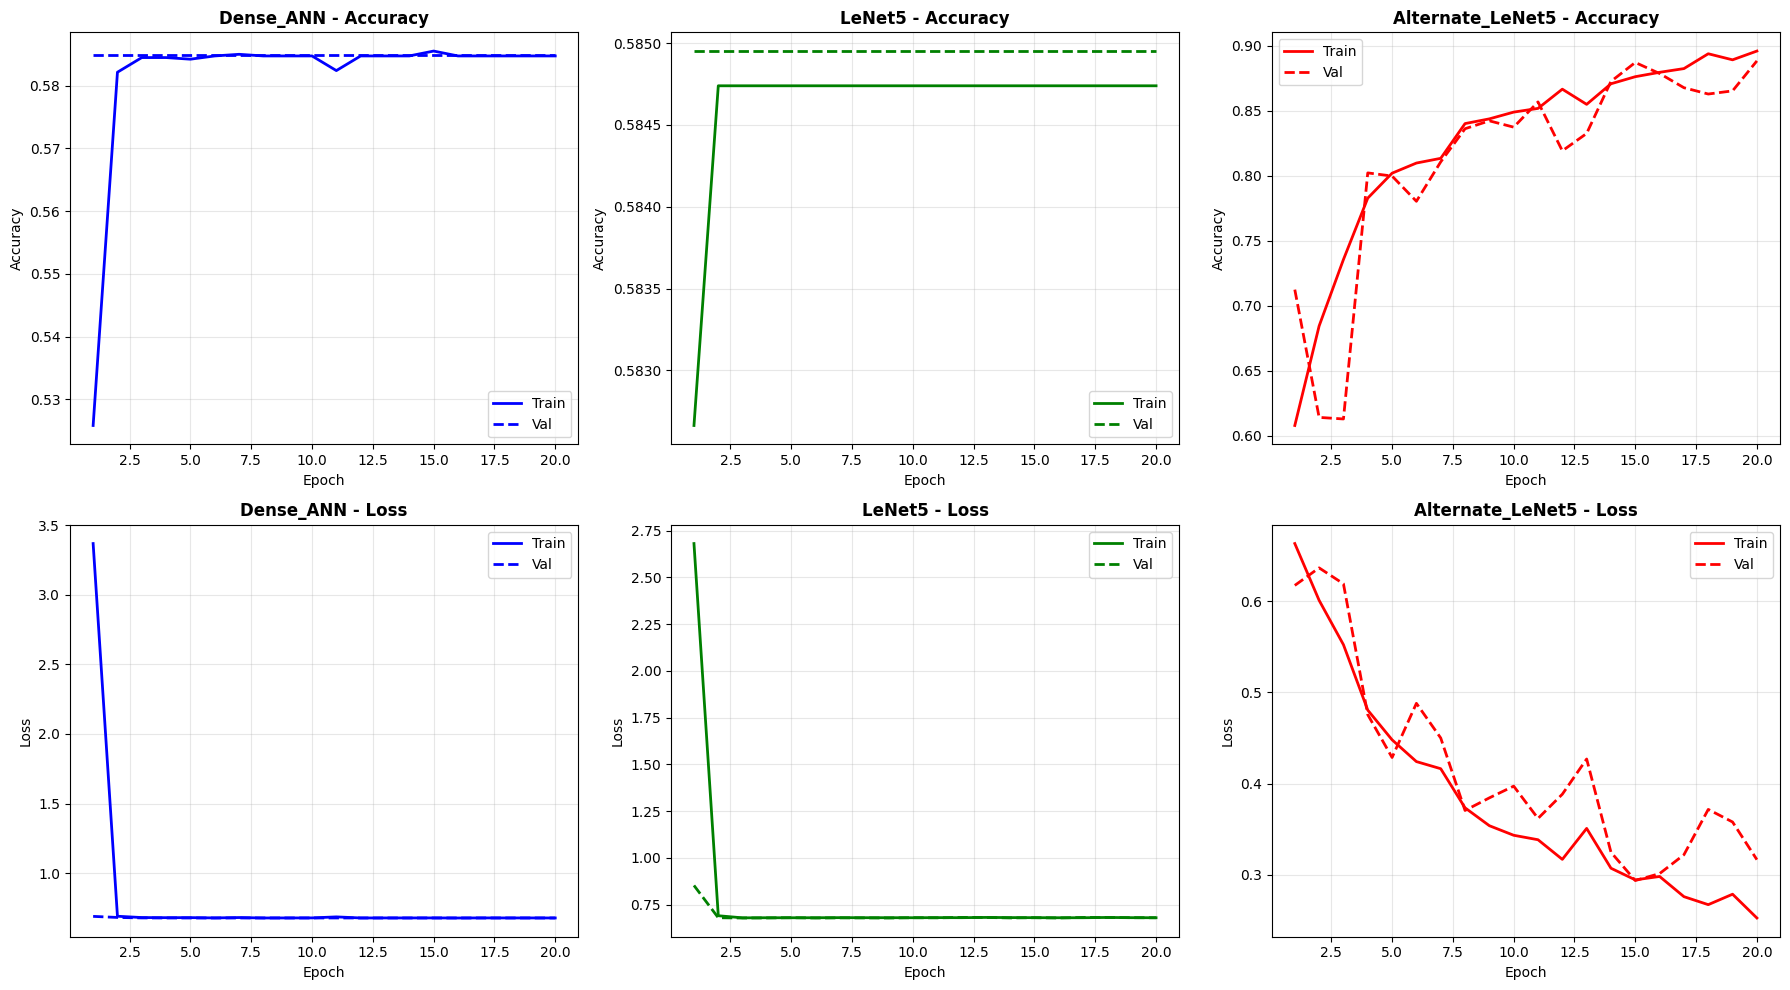

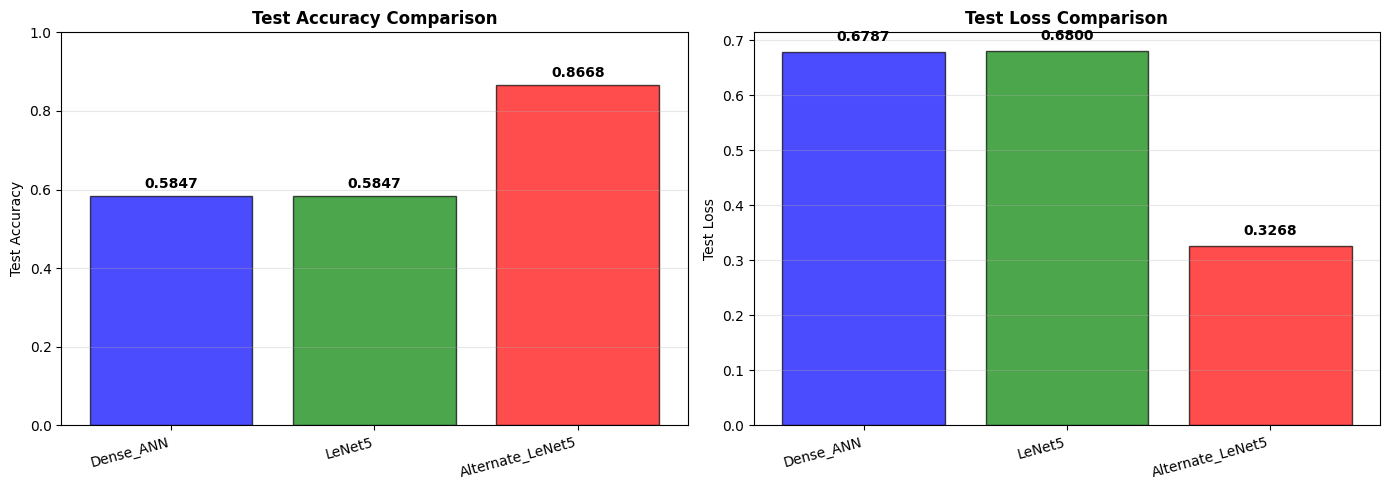


PROJECT COMPLETE!

Generated Files:
  - part1_samples.png
  - part1_analysis.png
  - preprocessing_params.json
  - model_dense_ann.h5
  - model_lenet5.h5
  - model_alternate_lenet5.h5
  - all_results.json
  - best_model_info.json
  - part2_training.png
  - part2_comparison.png

Best Model: Alternate_LeNet5 (Accuracy: 0.8668)

Ready for Part 3: Model Deployment!


In [35]:
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

print("\nTest Set Performance:")
print("-" * 60)
print(f"{'Model':<25} {'Accuracy':<15} {'Loss':<15}")
print("-" * 60)
for model_name, results in all_results.items():
    print(f"{model_name:<25} {results['test_accuracy']:<15.4f} {results['test_loss']:<15.4f}")
print("-" * 60)

best_model_name = max(all_results, key=lambda x: all_results[x]['test_accuracy'])
best_results = all_results[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"  Accuracy: {best_results['test_accuracy']:.4f}")
print(f"  Loss: {best_results['test_loss']:.4f}")

with open('all_results.json', 'w') as f:
    json.dump({
        'results': all_results,
        'best_model': best_model_name
    }, f, indent=4)

with open('best_model_info.json', 'w') as f:
    json.dump({
        'model_name': best_model_name,
        'img_size': IMG_SIZE,
        'test_accuracy': best_results['test_accuracy'],
        'test_loss': best_results['test_loss']
    }, f, indent=4)

print("\nResults saved")

# Visualize training
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
models = ['Dense_ANN', 'LeNet5', 'Alternate_LeNet5']
colors = ['blue', 'green', 'red']

for idx, (model_name, color) in enumerate(zip(models, colors)):
    history = all_histories[model_name]
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    axes[0, idx].plot(epochs_range, history['accuracy'], label='Train', color=color, linewidth=2)
    axes[0, idx].plot(epochs_range, history['val_accuracy'], label='Val', 
                     color=color, linestyle='--', linewidth=2)
    axes[0, idx].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Accuracy')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)
    
    axes[1, idx].plot(epochs_range, history['loss'], label='Train', color=color, linewidth=2)
    axes[1, idx].plot(epochs_range, history['val_loss'], label='Val',
                     color=color, linestyle='--', linewidth=2)
    axes[1, idx].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Loss')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('part2_training.png', dpi=150)
plt.show()

# Model comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

test_accs = [all_results[m]['test_accuracy'] for m in models]
axes[0].bar(range(len(models)), test_accs, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])
for i, v in enumerate(test_accs):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

test_losses = [all_results[m]['test_loss'] for m in models]
axes[1].bar(range(len(models)), test_losses, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Test Loss Comparison', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_losses):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('part2_comparison.png', dpi=150)
plt.show()

print("\n" + "=" * 80)
print("PROJECT COMPLETE!")
print("=" * 80)

print("\nGenerated Files:")
print("  - part1_samples.png")
print("  - part1_analysis.png")
print("  - preprocessing_params.json")
print("  - model_dense_ann.h5")
print("  - model_lenet5.h5")
print("  - model_alternate_lenet5.h5")
print("  - all_results.json")
print("  - best_model_info.json")
print("  - part2_training.png")
print("  - part2_comparison.png")

print(f"\nBest Model: {best_model_name} (Accuracy: {best_results['test_accuracy']:.4f})")
print("\nReady for Part 3: Model Deployment!")

In [39]:
# ============================================================================
# SAVE BEST MODEL
# ============================================================================

print("\n" + "=" * 80)
print("SAVING BEST MODEL")
print("=" * 80)

# Create harvey_destruction directory
import os
os.makedirs('harvey_destruction', exist_ok=True)

# Determine which model was best
best_model_name = max(all_results, key=lambda x: all_results[x]['test_accuracy'])

# Load the best model
if best_model_name == 'Dense_ANN':
    best_model = model_dense
elif best_model_name == 'LeNet5':
    best_model = model_lenet5
else:  # Alternate_LeNet5
    best_model = model_alt

# Save in both formats to harvey_destruction folder
best_model.save('harvey_destruction/best_hurricane_model.h5')
best_model.save('harvey_destruction/best_hurricane_model.keras')

print(f"\nBest model ({best_model_name}) saved to harvey_destruction/:")
print("  - harvey_destruction/best_hurricane_model.h5")
print("  - harvey_destruction/best_hurricane_model.keras")

# Also save as best_model.h5 for easy deployment
best_model.save('harvey_destruction/best_model.h5')
print("  - harvey_destruction/best_model.h5 (for deployment)")

# Save best_model_info.json in the same folder
import json
with open('harvey_destruction/best_model_info.json', 'w') as f:
    json.dump({
        'model_name': best_model_name,
        'img_size': IMG_SIZE,
        'test_accuracy': all_results[best_model_name]['test_accuracy'],
        'test_loss': all_results[best_model_name]['test_loss']
    }, f, indent=4)

print("  - harvey_destruction/best_model_info.json")

print("\n✓ All files saved to harvey_destruction/ folder")
print("\n" + "=" * 80)



SAVING BEST MODEL

Best model (Alternate_LeNet5) saved to harvey_destruction/:
  - harvey_destruction/best_hurricane_model.h5
  - harvey_destruction/best_hurricane_model.keras
  - harvey_destruction/best_model.h5 (for deployment)
  - harvey_destruction/best_model_info.json

✓ All files saved to harvey_destruction/ folder



In [49]:
import os

PROJECT_ROOT = "/code/Project2"
SERVER_DIR = os.path.join(PROJECT_ROOT, "server")
os.makedirs(SERVER_DIR, exist_ok=True)

# === app.py ===
app_py = """
from flask import Flask, request, jsonify
from PIL import Image
import io, json, numpy as np
from tensorflow import keras
import os

# Paths
APP_DIR = os.path.dirname(os.path.abspath(__file__))
ART_DIR = os.path.join(APP_DIR, "..", "artifacts")
MODEL_PATH = os.path.join(ART_DIR, "best_model.keras")
PREP_PATH = os.path.join(ART_DIR, "preprocessing.json")
CARD_PATH = os.path.join(ART_DIR, "model_card.json")

app = Flask(__name__)

# Load model and config on startup
print(f"Loading model from: {MODEL_PATH}")
model = keras.models.load_model(MODEL_PATH)

with open(PREP_PATH, "r") as f:
    prep = json.load(f)
W, H = prep["img_size"]
SCALE = prep["scale"]

with open(CARD_PATH, "r") as f:
    card = json.load(f)

@app.route("/summary", methods=["GET"])
def summary():
    \\\"\\\"\\\"Return model metadata\\\"\\\"\\\"
    return jsonify({
        "model_name": card.get("best_model_name", "Unknown"),
        "test_auc": card.get("test_auc", None),
        "input_size": [W, H, 3],
        "classes": ["no_damage", "damage"],
        "preprocessing": {
            "resize": [W, H],
            "scale": SCALE
        }
    })

@app.route("/inference", methods=["POST"])
def inference():
    \\\"\\\"\\\"Perform inference on uploaded image\\\"\\\"\\\"
    raw = request.get_data()
    if not raw:
        return jsonify({"error": "Empty request body"}), 400
    
    try:
        # Load and preprocess image
        im = Image.open(io.BytesIO(raw)).convert("RGB").resize((W, H))
        x = np.asarray(im, dtype=np.float32) * float(SCALE)
        x = x[None, ...]  # Add batch dimension: (1, H, W, 3)
        
        # Predict
        prob = float(model.predict(x, verbose=0).ravel()[0])
        label = "damage" if prob >= 0.5 else "no_damage"
        
        return jsonify({
            "prediction": label,
            "probability": prob
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)
"""
with open(os.path.join(SERVER_DIR, "app.py"), "w") as f:
    f.write(app_py.strip() + "\n")

# === requirements.txt ===
reqs = "\n".join([
    "flask==3.0.2",
    "pillow==10.4.0",
    "numpy==1.26.4",
    "tensorflow-cpu==2.14.0",
])
with open(os.path.join(SERVER_DIR, "requirements.txt"), "w") as f:
    f.write(reqs + "\n")

# === Dockerfile ===
dockerfile = """
FROM python:3.10-slim

ENV PIP_NO_CACHE_DIR=1 PYTHONUNBUFFERED=1
RUN apt-get update && apt-get install -y --no-install-recommends \\
    libglib2.0-0 libgl1 libjpeg62-turbo libpng16-16 libtiff5 libopenjp2-7 \\
    && rm -rf /var/lib/apt/lists/*

WORKDIR /app
COPY server/requirements.txt .
RUN pip install -r requirements.txt

COPY server/ /app/
COPY artifacts/ /app/artifacts/

EXPOSE 5000
CMD ["python", "app.py"]
"""
with open(os.path.join(PROJECT_ROOT, "Dockerfile"), "w") as f:
    f.write(dockerfile.strip() + "\n")

# === docker-compose.yml ===
compose = """
version: "3.8"
services:
  inference:
    build: .
    # After you push to Docker Hub, you can uncomment the next line:
    # image: YOUR_DOCKERHUB_USERNAME/harvey-inference:latest
    ports:
      - "5000:5000"
    volumes:
      - ./artifacts:/app/artifacts:ro
"""
with open(os.path.join(PROJECT_ROOT, "docker-compose.yml"), "w") as f:
    f.write(compose.strip() + "\n")

print("✓ Created server/app.py")
print("✓ Created server/requirements.txt")
print("✓ Created Dockerfile")
print("✓ Created docker-compose.yml")


✓ Created server/app.py
✓ Created server/requirements.txt
✓ Created Dockerfile
✓ Created docker-compose.yml
